In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline

In [62]:
from google.colab import drive
drive.mount('/content/drive')


data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic_train.csv', index_col='PassengerId').drop(['Ticket', 'Cabin', 'Name'], axis=1)
print(f'Всего данных: {data.shape[0]}')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Всего данных: 891


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [0]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

In [64]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
X_data = data.drop('Survived', axis=1)
X_data = pd.get_dummies(X_data, columns=['Sex', 'Embarked'])

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data['Survived'].copy()

# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(751, 10) (751, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [65]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[1.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.75770122, 0.        , 0.        , 0.31457232,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.1277244 , 1.        , 0.5       , 0.12783054,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.4305

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [0]:
from keras import callbacks

In [68]:
# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 751
Тренировочных данных: 601
Тестовых данных: 150
Размер данные для тренировки (входных): (601, 10)
Размер данные для тренировки (выходных): (601, 2)
Размер данные для теста (входных): (150, 10)
Размер данные для теста (выходных): (150, 2)


In [0]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [70]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 1s 1ms/step - loss: 0.5788 - categorical_accuracy: 0.7038 - val_loss: 0.5319 - val_categorical_accuracy: 0.7533
Epoch 2/100
601/601 [==============================] - 0s 419us/step - loss: 0.5181 - categorical_accuracy: 0.7804 - val_loss: 0.4942 - val_categorical_accuracy: 0.7867
Epoch 3/100
601/601 [==============================] - 0s 381us/step - loss: 0.4897 - categorical_accuracy: 0.7920 - val_loss: 0.4817 - val_categorical_accuracy: 0.7800
Epoch 4/100
601/601 [==============================] - 0s 407us/step - loss: 0.4765 - categorical_accuracy: 0.7920 - val_loss: 0.4749 - val_categorical_accuracy: 0.7867
Epoch 5/100
601/601 [==============================] - 0s 407us/step - loss: 0.4683 - categorical_accuracy: 0.7920 - val_loss: 0.4729 - val_categorical_accuracy: 0.7933
Epoch 6/100
601/601 [==============================] - 0s 389us/step - loss: 0.4659 - ca

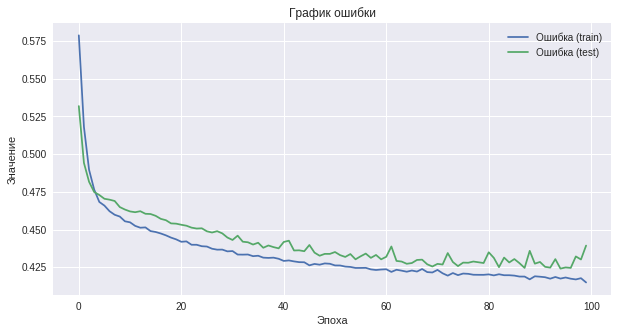

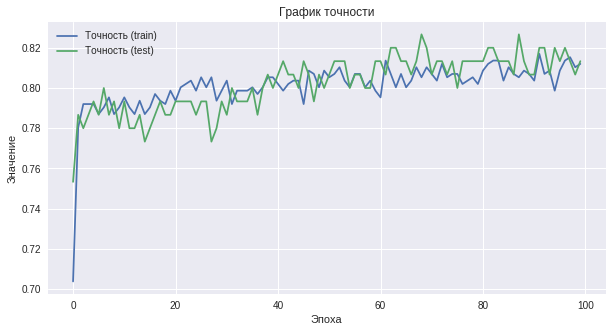

In [71]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [72]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 1s 1ms/step - loss: 0.6221 - categorical_accuracy: 0.6317 - val_loss: 0.5383 - val_categorical_accuracy: 0.7748
Epoch 2/100
600/600 [==============================] - 0s 358us/step - loss: 0.5485 - categorical_accuracy: 0.7633 - val_loss: 0.4839 - val_categorical_accuracy: 0.8278
Epoch 3/100
600/600 [==============================] - 0s 358us/step - loss: 0.5145 - categorical_accuracy: 0.7783 - val_loss: 0.4550 - val_categorical_accuracy: 0.8212
Epoch 4/100
600/600 [==============================] - 0s 366us/step - loss: 0.4971 - categorical_accuracy: 0.7917 - val_loss: 0.4395 - val_categorical_accuracy: 0.8146
Epoch 5/100
600/600 [==============================] - 0s 361us/step - loss: 0.4871 - categorical_accuracy: 0.7883 - val_loss: 0.4317 - val_categorical_accuracy: 0.8212
Epoch 6/100
600/600 [==============================] - 0s 367us/step - loss: 0.4820 - ca

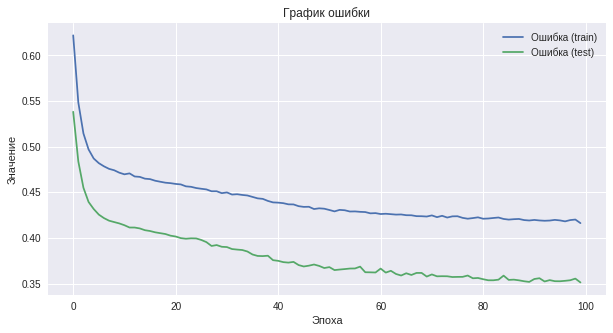

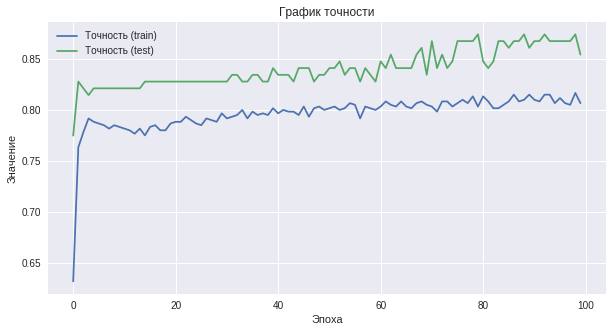

In [73]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [74]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 1s 1ms/step - loss: 0.6100 - categorical_accuracy: 0.7117 - val_loss: 0.5212 - val_categorical_accuracy: 0.8146
Epoch 2/300
600/600 [==============================] - 0s 395us/step - loss: 0.5424 - categorical_accuracy: 0.7800 - val_loss: 0.4837 - val_categorical_accuracy: 0.8079
Epoch 3/300
600/600 [==============================] - 0s 368us/step - loss: 0.5189 - categorical_accuracy: 0.7783 - val_loss: 0.4619 - val_categorical_accuracy: 0.8146
Epoch 4/300
600/600 [==============================] - 0s 370us/step - loss: 0.5061 - categorical_accuracy: 0.7800 - val_loss: 0.4486 - val_categorical_accuracy: 0.8146
Epoch 5/300
600/600 [==============================] - 0s 371us/step - loss: 0.4986 - categorical_accuracy: 0.7833 - val_loss: 0.4400 - val_categorical_accuracy: 0.8146
Epoch 6/300
600/600 [==============================] - 0s 369us/step - loss: 0.4920 - ca

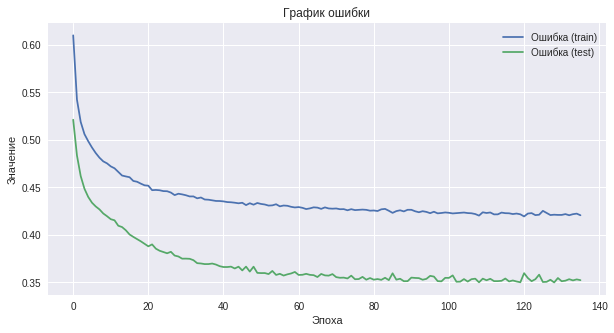

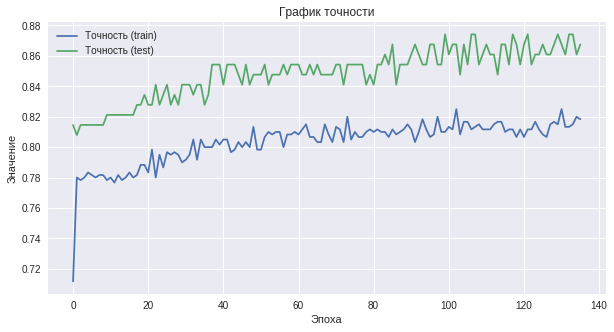

In [75]:

plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [0]:
from pathlib import Path
from os import remove

In [0]:
# создадим функцию создания и очистим каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('/content/drive/My Drive/Colab Notebooks/').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [78]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками /content/drive/My Drive/Colab Notebooks/save_points
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.99_val_loss-0.99_acc-0.56_val_acc-0.50.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.87_val_loss-0.89_acc-0.63_val_acc-0.55.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.75_val_loss-0.77_acc-0.70_val_acc-0.72.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.67_val_loss-0.68_acc-0.74_val_acc-0.76.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.62_val_loss-0.64_acc-0.78_val_acc-0.78.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.56_val_loss-0.59_acc-0.80_val_acc-0.78.hdf5
Удаляем файл /content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.54_val_loss-0.57_acc-0.81_val_acc-0.79.hdf5
Удаляем фай

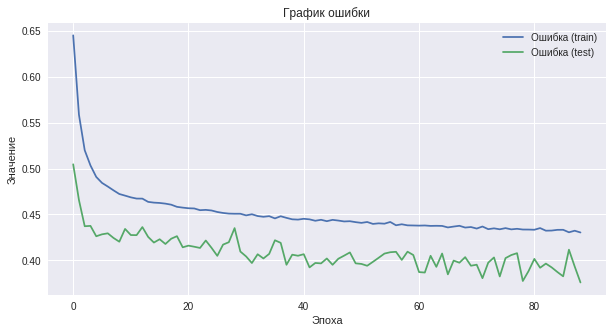

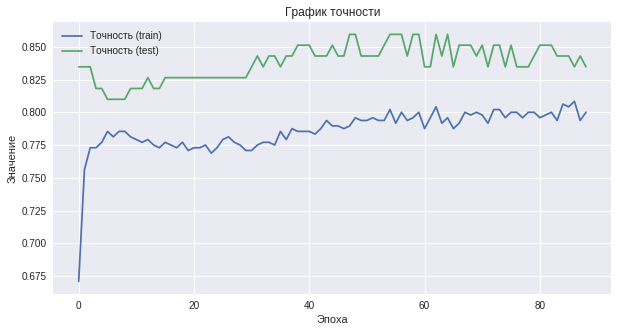

In [79]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [81]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('/content/drive/My Drive/Colab Notebooks/save_points/nn_model_loss-0.44_val_loss-0.41_acc-0.79_val_acc-0.85.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

601/601 [==============================] - 0s 443us/step
Точность предсказания на тренировочных данных 0.8019966711220448
150/150 [==============================] - 0s 59us/step
Точность предсказания на тестовых данных 0.7999999968210856


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [82]:
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
# Предсказываем вероятности для классов
loaded_model.predict(X_train)

array([[0.02546322, 0.9745368 ],
       [0.7772286 , 0.22277145],
       [0.8017902 , 0.19820978],
       ...,
       [0.15149191, 0.84850806],
       [0.90154773, 0.09845226],
       [0.05177058, 0.9482294 ]], dtype=float32)

In [0]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(751, 2)


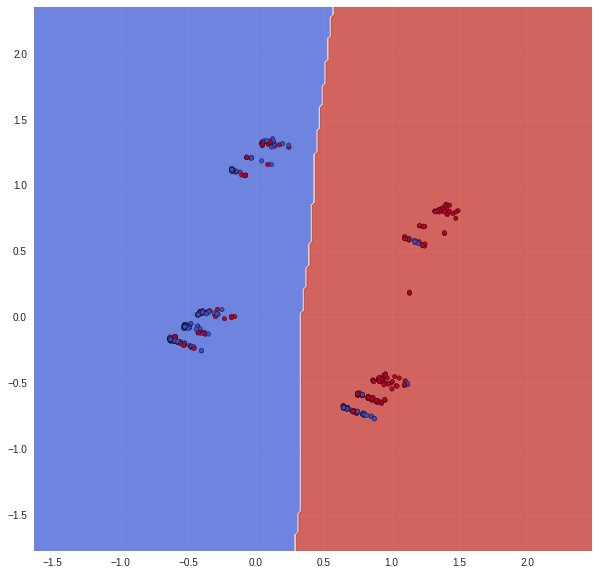

In [85]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_ready_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')